# Dataset
---



In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ashishmotwani/tomato")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tomato


In [2]:

train_dir = path + '/train/'
valid_dir = path + '/valid/'

## Visualisation

                                      Count
Late_blight                            3113
healthy                                3051
Septoria_leaf_spot                     2882
Bacterial_spot                         2826
Leaf_Mold                              2754
Early_blight                           2455
Tomato_mosaic_virus                    2153
Tomato_Yellow_Leaf_Curl_Virus          2039
Target_Spot                            1827
Spider_mites Two-spotted_spider_mite   1747
powdery_mildew                         1004


<Figure size 1200x600 with 0 Axes>

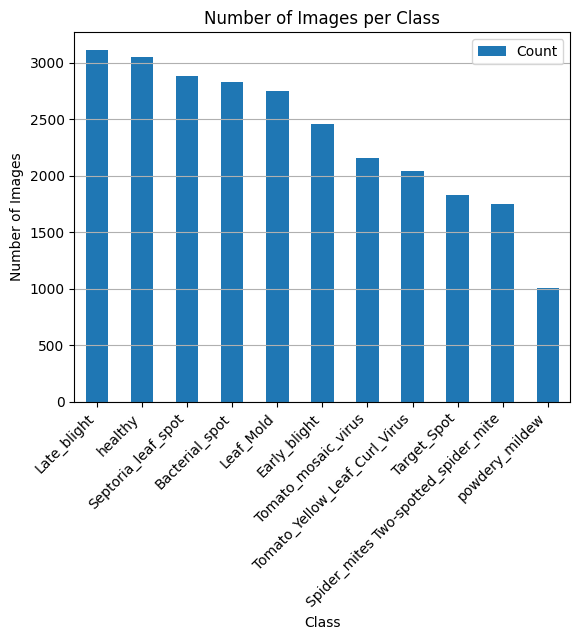

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt


# List all classes
classes = os.listdir(train_dir)

class_counts = {}

for cls in classes:
    cls_path = os.path.join(train_dir, cls)
    if os.path.isdir(cls_path):
        class_counts[cls] = len(os.listdir(cls_path))

# Convert to pandas DataFrame
class_counts_df = pd.DataFrame.from_dict(class_counts, orient='index', columns=['Count'])
class_counts_df = class_counts_df.sort_values('Count', ascending=False)

print(class_counts_df)

# Plot
plt.figure(figsize=(12,6))
class_counts_df.plot(kind='bar')
plt.title("Number of Images per Class")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.show()


In [ ]:
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import os

# Consistent size everywhere
img_height, img_width = 224, 224

# Number of images per class
num_images = 4

# Calculate how many rows you need
n_classes = len(classes)
rows = n_classes
cols = num_images

# Set overall figure size to avoid scrolling (adjust if needed)
plt.figure(figsize=(num_images * 3, n_classes * 3))  # width, height in inches

# Plot images
for idx, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    img_files = os.listdir(cls_path)
    selected_imgs = random.sample(img_files, num_images)

    for j, img_name in enumerate(selected_imgs):
        img_path = os.path.join(cls_path, img_name)
        img = image.load_img(img_path, target_size=(img_height, img_width))

        plt.subplot(rows, cols, idx * num_images + j + 1)
        plt.imshow(img)
        plt.axis('off')
        if j == 1:  # Show class label only once per row (center image)
            plt.title(cls, fontsize=10, color='darkblue')

plt.tight_layout()
plt.show()


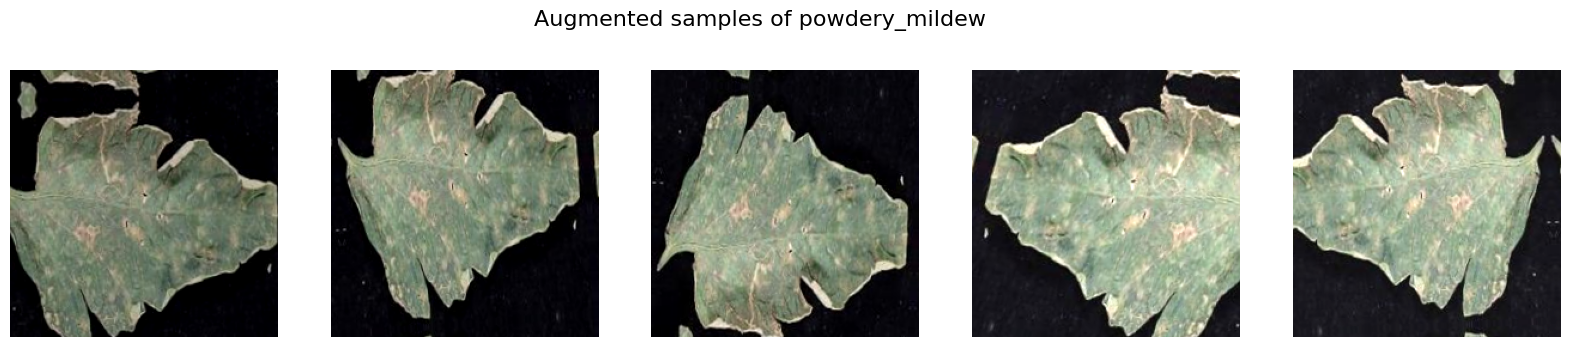

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup a basic ImageDataGenerator for augmentation preview
aug_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,          # Slightly higher rotation
    zoom_range=0.15,             # Good zoom
    horizontal_flip=True,        # Flip left-right
    vertical_flip=True,          # Flip up-down (can help sometimes)
    width_shift_range=0.1,      # More shift
    height_shift_range=0.1,           # New: Shearing transformation
    brightness_range=[0.9, 1.2], # New: Random brightness
    channel_shift_range=20.0,    # New: Slight color channel shift
    fill_mode='reflect'          # Fill empty pixels after transforms
)

# Choose any random class and image
cls_sample = random.choice(classes)
cls_path = os.path.join(train_dir, cls_sample)
img_file = random.choice(os.listdir(cls_path))
img_path = os.path.join(cls_path, img_file)

img = image.load_img(img_path, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = img_array.reshape((1,) + img_array.shape)

# Plot augmented images
plt.figure(figsize=(20,4))
i = 0
for batch in aug_datagen.flow(img_array, batch_size=1):
    plt.subplot(1, 5, i+1)
    plt.imshow(batch[0])
    plt.axis('off')
    if i == 4:
        break
    i += 1

plt.suptitle(f'Augmented samples of {cls_sample}', fontsize=16)
plt.show()


# EfficientNetB0

In [6]:
import kagglehub
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Train generator with augmentations
train_datagen = ImageDataGenerator(
    # preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.15,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.2],
    channel_shift_range=20.0,
    fill_mode='reflect'
)

val_datagen = ImageDataGenerator(

)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [5]:
val_generator.class_indices.items()

dict_items([('Bacterial_spot', 0), ('Early_blight', 1), ('Late_blight', 2), ('Leaf_Mold', 3), ('Septoria_leaf_spot', 4), ('Spider_mites Two-spotted_spider_mite', 5), ('Target_Spot', 6), ('Tomato_Yellow_Leaf_Curl_Virus', 7), ('Tomato_mosaic_virus', 8), ('healthy', 9), ('powdery_mildew', 10)])

In [11]:
# EfficientNetB0 Model
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

# Base model
base_model = tf.keras.applications.EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg'
)
# Freeze base model (optional, depending on fine-tuning strategy)
base_model.trainable = False

x = base_model.output
x = Dense(1024, activation='relu')(x)
x = Dropout(0.1)(x)
prediction = Dense(11, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=prediction)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_4 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_2           │ (None, 224, 224, 3)    │              7 │ rescaling_4[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_5 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_5[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 5,372,590 (20.49 MB)

 Trainable params: 1,323,019 (5.05 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [12]:
model.compile(Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(
    x=train_generator,
    validation_data=val_generator,
    epochs=10, verbose=1,
    validation_steps=None, shuffle=False
)

Epoch 1/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 578s 686ms/step - accuracy: 0.7090 - loss: 0.8494 - val_accuracy: 0.8692 - val_loss: 0.3754
Epoch 2/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 414s 513ms/step - accuracy: 0.8825 - loss: 0.3367 - val_accuracy: 0.9184 - val_loss: 0.2422
Epoch 3/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 420s 519ms/step - accuracy: 0.9078 - loss: 0.2644 - val_accuracy: 0.9370 - val_loss: 0.2032
Epoch 4/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 416s 515ms/step - accuracy: 0.9227 - loss: 0.2229 - val_accuracy: 0.9316 - val_loss: 0.2111
Epoch 5/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 418s 518ms/step - accuracy: 0.9345 - loss: 0.1956 - val_accuracy: 0.9391 - val_loss: 0.1832
Epoch 6/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 420s 520ms/step - accuracy: 0.9398 - loss: 0.1727 - val_accuracy: 0.9300 - val_loss: 0.2133
Epoch 7/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 445s 524ms/step - accuracy: 0.9501 - loss: 0.1464 - val_accuracy: 0.9337 - val_loss: 0.2091
Epoch 8/10
808/808 ━━━━━━━━━━━━━━━━━━━━ 422s 522ms/step - accuracy: 0.9494 -

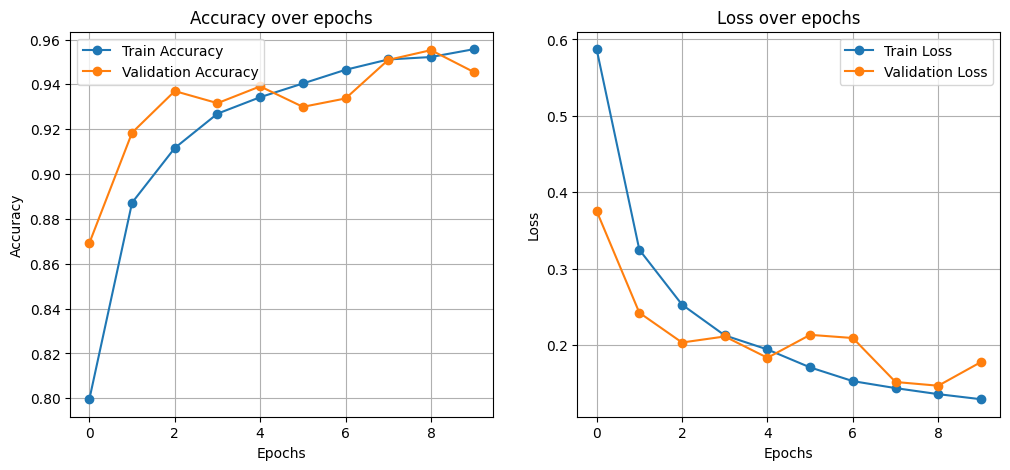

In [17]:
import matplotlib.pyplot as plt

# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()


In [13]:
from google.colab import drive
drive.mount('/content/drive')
model_save_path = '/content/drive/My Drive/efficentNetB0.h5'
model.save(model_save_path)


Mounted at /content/drive


In [15]:
from google.colab import drive
from tensorflow.keras.models import load_model
drive.mount('/content/drive')
model_path_eff = '/content/drive/My Drive/efficentNetB0.h5'
model_eff = load_model(model_path_eff)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
)


train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)



Found 25851 images belonging to 11 classes.
Found 6683 images belonging to 11 classes.


In [16]:
# Scores is just a list containing loss and accuracy value # VGG19
scores_eff=model_eff.evaluate(train_generator)
scores2_eff=model_eff.evaluate(val_generator)
# print("Training Loss is :"+str(scores[0]))
print("Training Accuracy is :"+str(scores_eff[1]*100)+" %")
# print("Testing Loss is : "+str(scores2[0]))
print("Testing Accuracy is : "+str(scores2_eff[1]*100)+" %")

808/808 ━━━━━━━━━━━━━━━━━━━━ 91s 102ms/step - accuracy: 0.9615 - loss: 0.1129
209/209 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.9463 - loss: 0.1768
Training Accuracy is :96.32896184921265 %
Testing Accuracy is : 94.55334544181824 %


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict the labels
y_pred = model_eff.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # for multi-class classification

# True labels
y_true = val_generator.classes



209/209 ━━━━━━━━━━━━━━━━━━━━ 52s 191ms/step


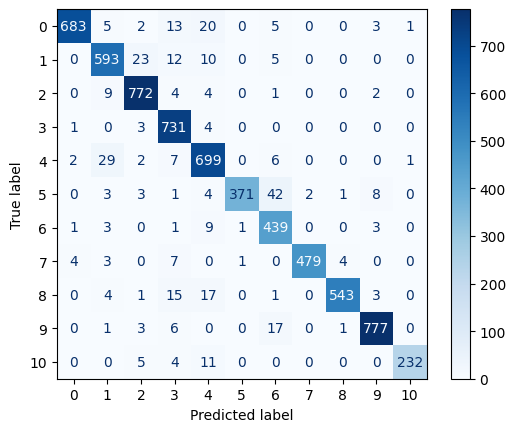

In [19]:

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.show()

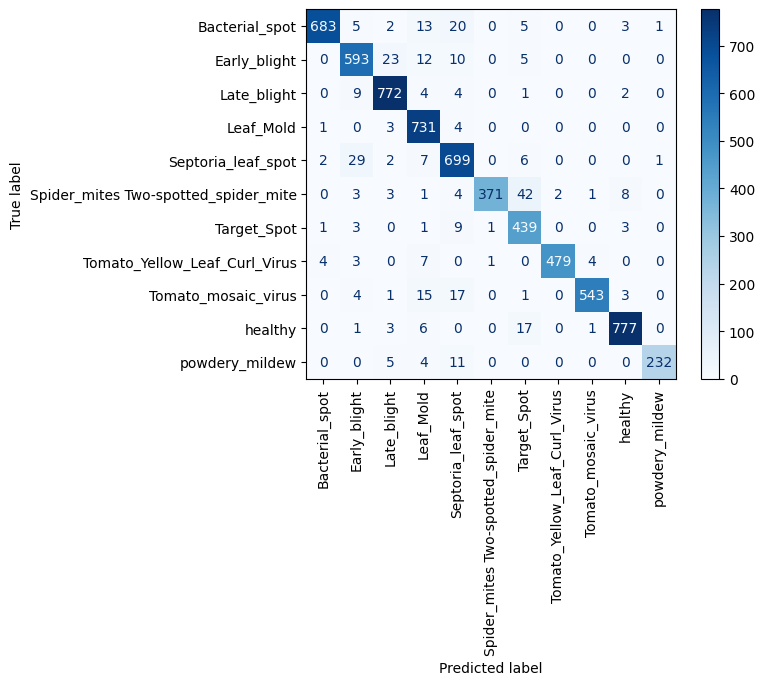

In [20]:
class_labels = list(val_generator.class_indices.keys())
# Display confusion matrix with class labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=90)  # Rotating x labels a bit
plt.show()

In [21]:
from sklearn.metrics import classification_report
report = classification_report(y_true, y_pred_classes, target_names=class_labels)
print(report)

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.99      0.93      0.96       732
                        Early_blight       0.91      0.92      0.92       643
                         Late_blight       0.95      0.97      0.96       792
                           Leaf_Mold       0.91      0.99      0.95       739
                  Septoria_leaf_spot       0.90      0.94      0.92       746
Spider_mites Two-spotted_spider_mite       0.99      0.85      0.92       435
                         Target_Spot       0.85      0.96      0.90       457
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.96      0.98       498
                 Tomato_mosaic_virus       0.99      0.93      0.96       584
                             healthy       0.98      0.97      0.97       805
                      powdery_mildew       0.99      0.92      0.95       252

                            accuracy                          